# KAN: Kolmogorov–Arnold Networks With ......

Implementation of KAN architecture with proper feature extraction and attention mechanisms for MRI image analysis.

## 1. Import Dependencies

Import required libraries and modules for implementing KAN.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

## 2. Data Loading and Preprocessing

Setup data pipelines with proper transforms for MRI images.

In [2]:
# Data directories
TRAIN_DIR = "/home/mhs/research/thesis/Brain MRI ND-5 Dataset/Training"
TEST_DIR  = "/home/mhs/research/thesis/Brain MRI ND-5 Dataset/Testing"

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((64, 64)),                # Resize for backbone
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat grayscale to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])   # ImageNet normalization
])

from torch.utils.data import Subset
import random

# Create datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)

# # Create subsets properly
# # Method 1: Random selection of indices
# train_indices = random.sample(range(len(train_dataset)), min(5000, len(train_dataset)))
# test_indices = random.sample(range(len(test_dataset)), min(500, len(test_dataset)))

# # Create subset datasets
# train_dataset = Subset(train_dataset, train_indices)
# test_dataset = Subset(test_dataset, test_indices)

# Alternative Method 2: Take the first N samples
# train_dataset = Subset(train_dataset, list(range(min(1000, len(train_dataset)))))
# test_dataset = Subset(test_dataset, list(range(min(500, len(test_dataset)))))

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)

# When printing class counts, we need to access the original dataset's classes
original_train_dataset = datasets.ImageFolder(TRAIN_DIR)
num_classes = len(original_train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Number of classes: 4
Training samples: 13927
Testing samples: 3961


## 3. Define KAN Architecture

Implement the Kernel Attention Network model with proper feature extraction.

In [3]:
# class KernelAttention(nn.Module):
#     def __init__(self, in_dim, kernel_size=7):
#         super().__init__()
#         self.conv = nn.Conv2d(in_dim, in_dim, kernel_size=kernel_size, 
#                              padding=kernel_size//2, groups=in_dim)
#         self.spatial_gate = nn.Sequential(
#             nn.Conv2d(in_dim, 1, kernel_size=1),
#             nn.Sigmoid()
#         )
        
#     def forward(self, x):
#         # Local feature aggregation
#         local_feat = self.conv(x)
#         # Generate attention weights
#         attn = self.spatial_gate(local_feat)
#         return x * attn

# class KANModel(nn.Module):
#     def __init__(self, num_classes, backbone='resnet18'):
#         super().__init__()
        
#         # 1. Feature Extraction Backbone
#         if backbone == 'resnet18':
#             base = models.resnet18(pretrained=True)
#             self.feature_dim = 512
#         else:
#             raise ValueError(f"Unsupported backbone: {backbone}")
            
#         # Remove the final FC layer
#         self.features = nn.Sequential(*list(base.children())[:-2])
        
#         # 2. Kernel Attention Module
#         self.attention = KernelAttention(self.feature_dim)
        
#         # 3. Global Average Pooling
#         self.gap = nn.AdaptiveAvgPool2d(1)
        
#         # 4. Classifier
#         self.classifier = nn.Sequential(
#             nn.Linear(self.feature_dim, 256),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )
        
#     def forward(self, x):
#         # Extract features
#         x = self.features(x)  # [B, 512, H', W']
        
#         # Apply kernel attention
#         x = self.attention(x)
        
#         # Global average pooling
#         x = self.gap(x)      # [B, 512, 1, 1]
#         x = x.view(x.size(0), -1)  # [B, 512]
        
#         # Classification
#         return self.classifier(x)

In [4]:
# class BSpline(nn.Module):
#     """B-spline implementation for KAN."""

#     def __init__(self, in_dim, grid_size=5, degree=3):
#         super().__init__()
#         self.in_dim = in_dim
#         self.grid_size = grid_size
#         self.degree = degree

#         # Learnable control points - one set for each channel
#         self.control_points = nn.Parameter(torch.randn(in_dim, grid_size))

#         # Fixed grid points from 0 to 1
#         self.register_buffer("grid", torch.linspace(0, 1, grid_size))

#     def forward(self, x):
#         # x shape: [B, C, N]
#         B, C, N = x.shape

#         # Ensure C matches in_dim
#         assert (
#             C == self.in_dim
#         ), f"Input has {C} channels but BSpline expects {self.in_dim}"

#         # Normalize input to [0, 1]
#         x_min = x.min(dim=2, keepdim=True)[0]
#         x_max = x.max(dim=2, keepdim=True)[0]
#         x_norm = (x - x_min) / (x_max - x_min + 1e-8)

#         # Initialize output tensor
#         out = torch.zeros_like(x)

#         # Compute B-spline weights for each channel
#         for c in range(C):
#             # Expand grid for broadcasting
#             grid_expanded = self.grid.view(1, -1)  # [1, grid_size]
#             x_expanded = x_norm[:, c, :].unsqueeze(2)  # [B, N, 1]

#             # Compute weights using RBF
#             weights = torch.exp(
#                 -((x_expanded - grid_expanded) ** 2) / 0.1
#             )  # [B, N, grid_size]
#             weights = weights / (weights.sum(dim=2, keepdim=True) + 1e-8)

#             # Apply weights to control points
#             out[:, c, :] = torch.matmul(
#                 weights, self.control_points[c].unsqueeze(1)
#             ).squeeze(2)

#         return out


# class KANAttention(nn.Module):
#     def __init__(self, in_dim, grid_size=5, degree=3):
#         super().__init__()
#         self.in_dim = in_dim

#         # Modified KAN layer
#         self.spline = BSpline(in_dim, grid_size, degree)
#         self.attention_conv = nn.Conv1d(in_dim, 1, 1)
#         self.activation = nn.Sigmoid()

#     def forward(self, x):
#         # x: [B, C, H, W]
#         B, C, H, W = x.shape

#         # Reshape to [B, C, H*W]
#         x_flat = x.view(B, C, -1)

#         # Apply B-spline transformation
#         x_spline = self.spline(x_flat)

#         # Generate attention weights
#         attn = self.attention_conv(x_spline)  # [B, 1, H*W]
#         attn = self.activation(attn)

#         # Reshape attention back to spatial dimensions
#         attn = attn.view(B, 1, H, W)

#         # Apply attention
#         return x * attn.expand_as(x)


# class KANModel(nn.Module):
#     def __init__(self, num_classes, backbone="mobilenetv3"):
#         super().__init__()

#         # 1. Feature Extraction Backbone
#         if backbone == "resnet18":
#             base = models.resnet18(pretrained=True)
#             self.feature_dim = 512
#             # Remove final FC layer and keep feature extractor
#             self.features = nn.Sequential(*list(base.children())[:-2])
#         elif backbone == "mobilenetv3":
#             base = models.mobilenet_v3_small(
#                 weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
#             )
#             # For MobileNetV3, we need to determine the feature dimension correctly
#             self.feature_dim = (
#                 576  # MobileNetV3-Small has 576 channels in its last conv layer
#             )
#             # Replace classifier but keep features
#             self.features = base.features
#         else:
#             raise ValueError(f"Unsupported backbone: {backbone}")

#         # 2. KAN Attention Module
#         self.attention = KANAttention(self.feature_dim)

#         # 3. Global Average Pooling
#         self.gap = nn.AdaptiveAvgPool2d(1)

#         # 4. Final Classifier
#         self.classifier = nn.Sequential(
#             nn.Linear(self.feature_dim, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes),
#         )

#     def forward(self, x):
#         # Feature extraction
#         x = self.features(x)  # [B, feature_dim, H', W']

#         # Apply KAN attention
#         x = self.attention(x)

#         # Global average pooling
#         x = self.gap(x)  # [B, feature_dim, 1, 1]
#         x = x.view(x.size(0), -1)  # [B, feature_dim]

#         # Classification
#         return self.classifier(x)

In [5]:
# class KANModel(nn.Module):
#     def __init__(self, num_classes, backbone="mobilenetv3"):
#         super().__init__()

#         # 1. Feature Extraction Backbone
#         if backbone == "resnet18":
#             base = models.resnet18(pretrained=True)
#             self.feature_dim = 512
#         elif backbone == "mobilenetv3":
#             base = models.mobilenet_v3_small(
#                 weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
#             )
#             self.feature_dim = 512
#         else:
#             raise ValueError(f"Unsupported backbone: {backbone}")

#         # Remove final FC layer and keep feature extractor
#         self.features = nn.Sequential(*list(base.children())[:-2])

#         # 2. KAN Attention Module
#         self.attention = KANAttention(self.feature_dim)

#         # 3. Global Average Pooling
#         self.gap = nn.AdaptiveAvgPool2d(1)

#         # 4. Final Classifier
#         self.classifier = nn.Sequential(
#             nn.Linear(self.feature_dim, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes),
#         )

#     def forward(self, x):
#         # Feature extraction
#         x = self.features(x)  # [B, 512, H', W']

#         # Apply KAN attention
#         x = self.attention(x)

#         # Global average pooling
#         x = self.gap(x)  # [B, 512, 1, 1]
#         x = x.view(x.size(0), -1)  # [B, 512]

#         # Classification
#         return self.classifier(x)

In [6]:
class SpatialBSpline(nn.Module):
    """Optimized 2D B-spline implementation"""
    def __init__(self, in_channels, out_channels, grid_size=5):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.grid_size = grid_size
        
        # Reduce parameter count with single-channel control points that get mapped to output
        self.control_points = nn.Parameter(torch.randn(grid_size * grid_size, in_channels))
        # Linear mapping to output channels instead of separate control points per output
        self.channel_map = nn.Linear(in_channels, out_channels)
        
        # Create 2D grid once during initialization
        x = torch.linspace(0, 1, grid_size)
        y = torch.linspace(0, 1, grid_size)
        xx, yy = torch.meshgrid(x, y, indexing="ij")
        grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)
        self.register_buffer("grid", grid)  # [grid_size^2, 2]
        
    def forward(self, x):
        # x: [B, C_in, H, W]
        B, C_in, H, W = x.shape
        
        # Normalize spatial coordinates to [0,1] for grid lookup
        h_norm = torch.linspace(0, 1, H, device=x.device)
        w_norm = torch.linspace(0, 1, W, device=x.device)
        norm_h, norm_w = torch.meshgrid(h_norm, w_norm, indexing="ij")
        positions = torch.stack([norm_h.flatten(), norm_w.flatten()], dim=1)  # [H*W, 2]
        
        # Compute spatial distances to grid points - do this once
        dist_to_grid = torch.cdist(positions, self.grid, p=2)  # [H*W, grid_size^2]
        
        # Calculate RBF kernel weights from spatial distances
        sigma = 0.2
        spatial_weights = torch.exp(-dist_to_grid / sigma)  # [H*W, grid_size^2]
        spatial_weights = spatial_weights / (spatial_weights.sum(dim=1, keepdim=True) + 1e-8)
        
        # Process data for all batches and channels at once
        x_flat = x.permute(0, 2, 3, 1).reshape(B * H * W, C_in)  # [B*H*W, C_in]
        
        # Apply control points
        weighted_controls = torch.matmul(spatial_weights, self.control_points)  # [H*W, C_in]
        weighted_controls = weighted_controls.unsqueeze(0).expand(B, -1, -1)  # [B, H*W, C_in]
        weighted_controls = weighted_controls.reshape(B * H * W, C_in)
        
        # Element-wise multiplication with input features
        combined = weighted_controls * x_flat  # [B*H*W, C_in]
        
        # Map to output channels
        output = self.channel_map(combined)  # [B*H*W, C_out]
        
        # Reshape back to spatial dimensions
        output = output.reshape(B, H, W, self.out_channels).permute(0, 3, 1, 2)
        
        return output

class PureBSplineBlock(nn.Module):
    """Lightweight block using B-splines"""
    def __init__(self, in_channels, out_channels, grid_size=5):
        super().__init__()
        
        # Feature transformation with B-splines
        self.spatial_spline = SpatialBSpline(
            in_channels, out_channels, grid_size=grid_size
        )
        
        # Normalization and activation
        self.norm = nn.LayerNorm(out_channels)
        self.act = nn.GELU()
        
        # Simple attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(out_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Apply spatial B-spline
        features = self.spatial_spline(x)
        
        # Layer normalization across channels
        B, C, H, W = features.shape
        features = features.permute(0, 2, 3, 1)  # [B, H, W, C]
        features = self.norm(features)
        features = features.permute(0, 3, 1, 2)  # [B, C, H, W]
        features = self.act(features)
        
        # Apply simple attention
        attention = self.attention(features)
        
        # Apply attention weights
        return features * attention

class PureKANModel(nn.Module):
    """Lightweight image classifier using B-splines"""
    def __init__(self, num_classes, in_channels=3):
        super().__init__()
        
        # Initial feature extraction
        self.input_proj = nn.Linear(in_channels, 32)
        
        # Smaller and fewer B-spline blocks
        self.block1 = PureBSplineBlock(32, 64, grid_size=5)
        self.pool1 = nn.AvgPool2d(2)
        
        self.block2 = PureBSplineBlock(64, 128, grid_size=5)
        self.pool2 = nn.AvgPool2d(2)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        # Initial projection
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1)  # [B, H, W, C]
        x = self.input_proj(x)  # [B, H, W, 32]
        x = x.permute(0, 3, 1, 2)  # [B, 32, H, W]
        
        # Process through B-spline blocks
        x = self.block1(x)
        x = self.pool1(x)
        
        x = self.block2(x)
        x = self.pool2(x)
        
        # Global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        # Classification
        return self.classifier(x)

## 4. Training Configuration

Setup training parameters and optimization configuration.

In [7]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = PureKANModel(num_classes=num_classes, in_channels=3).to(device)
# Possibly lower learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Initialize model
# model = KANModel(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Learning rate scheduler (removed verbose parameter)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=5
)

Using device: cuda


## 5. Training and Evaluation Loop

Implement the main training loop with evaluation metrics.

In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Compute epoch metrics
    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

# First, store the class names before creating the subsets
original_train_dataset = datasets.ImageFolder(TRAIN_DIR)
class_names = original_train_dataset.classes

# Now modify the evaluate function
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    avg_loss = running_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, 
                                target_names=class_names)  # Use the stored class_names here
    
    return avg_loss, accuracy, report

# Define number of epochs
num_epochs = 300  # Set an appropriate number of epochs

# The rest of your training loop remains unchanged
best_acc = 0.0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                      optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluation phase
    val_loss, val_acc, val_report = evaluate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'kan_best_model.pth')

    # Print epoch results
    print(f"\nEpoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Print detailed validation report every 5 epochs
    if epoch % 5 == 0:
        print("\nValidation Report:")
        print(val_report)

# Final evaluation
print("\nLoading best model for final evaluation...")
model.load_state_dict(torch.load('kan_best_model.pth'))
test_loss, test_acc, test_report = evaluate(model, test_loader, criterion, device)

print("\nFinal Test Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nDetailed Classification Report:")
print(test_report)

Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.89it/s]



Epoch 1/300
Train Loss: 1.0669, Train Acc: 0.5166
Val Loss: 0.9027, Val Acc: 0.6236


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.08it/s]



Epoch 2/300
Train Loss: 0.7772, Train Acc: 0.6821
Val Loss: 0.8424, Val Acc: 0.6718


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.79it/s]



Epoch 3/300
Train Loss: 0.7117, Train Acc: 0.7068
Val Loss: 0.7735, Val Acc: 0.6907


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.90it/s]



Epoch 4/300
Train Loss: 0.6633, Train Acc: 0.7289
Val Loss: 0.7506, Val Acc: 0.7051


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.66it/s]



Epoch 5/300
Train Loss: 0.6487, Train Acc: 0.7345
Val Loss: 0.7758, Val Acc: 0.7011

Validation Report:
              precision    recall  f1-score   support

      glioma       0.70      0.68      0.69      1208
  meningioma       0.58      0.54      0.56       930
        none       0.77      0.79      0.78       831
   pituitary       0.75      0.80      0.77       992

    accuracy                           0.70      3961
   macro avg       0.70      0.70      0.70      3961
weighted avg       0.70      0.70      0.70      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.68it/s]



Epoch 6/300
Train Loss: 0.6313, Train Acc: 0.7432
Val Loss: 0.7258, Val Acc: 0.7258


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.22it/s]



Epoch 7/300
Train Loss: 0.6026, Train Acc: 0.7569
Val Loss: 0.7272, Val Acc: 0.7286


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.87it/s]



Epoch 8/300
Train Loss: 0.5985, Train Acc: 0.7561
Val Loss: 0.7478, Val Acc: 0.7185


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.63it/s]



Epoch 9/300
Train Loss: 0.5847, Train Acc: 0.7636
Val Loss: 0.7664, Val Acc: 0.7294


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.57it/s]



Epoch 10/300
Train Loss: 0.5702, Train Acc: 0.7714
Val Loss: 0.7922, Val Acc: 0.7087

Validation Report:
              precision    recall  f1-score   support

      glioma       0.67      0.75      0.71      1208
  meningioma       0.57      0.64      0.60       930
        none       0.81      0.82      0.81       831
   pituitary       0.87      0.63      0.73       992

    accuracy                           0.71      3961
   macro avg       0.73      0.71      0.71      3961
weighted avg       0.72      0.71      0.71      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.49it/s]



Epoch 11/300
Train Loss: 0.5635, Train Acc: 0.7728
Val Loss: 0.7349, Val Acc: 0.7344


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.90it/s]



Epoch 12/300
Train Loss: 0.5476, Train Acc: 0.7753
Val Loss: 0.6822, Val Acc: 0.7392


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.29it/s]



Epoch 13/300
Train Loss: 0.5413, Train Acc: 0.7841
Val Loss: 0.6995, Val Acc: 0.7465


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.07it/s]



Epoch 14/300
Train Loss: 0.5231, Train Acc: 0.7915
Val Loss: 0.7186, Val Acc: 0.7443


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.77it/s]



Epoch 15/300
Train Loss: 0.5180, Train Acc: 0.7955
Val Loss: 0.6713, Val Acc: 0.7650

Validation Report:
              precision    recall  f1-score   support

      glioma       0.78      0.70      0.74      1208
  meningioma       0.64      0.67      0.66       930
        none       0.79      0.90      0.85       831
   pituitary       0.84      0.81      0.82       992

    accuracy                           0.76      3961
   macro avg       0.76      0.77      0.77      3961
weighted avg       0.77      0.76      0.76      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.12it/s]



Epoch 16/300
Train Loss: 0.5068, Train Acc: 0.8013
Val Loss: 0.6836, Val Acc: 0.7556


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.02it/s]



Epoch 17/300
Train Loss: 0.5002, Train Acc: 0.8038
Val Loss: 0.6498, Val Acc: 0.7804


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.21it/s]



Epoch 18/300
Train Loss: 0.4847, Train Acc: 0.8104
Val Loss: 0.7226, Val Acc: 0.7660


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.86it/s]



Epoch 19/300
Train Loss: 0.4844, Train Acc: 0.8062
Val Loss: 0.7015, Val Acc: 0.7642


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.83it/s]



Epoch 20/300
Train Loss: 0.4687, Train Acc: 0.8198
Val Loss: 0.6595, Val Acc: 0.7816

Validation Report:
              precision    recall  f1-score   support

      glioma       0.82      0.73      0.77      1208
  meningioma       0.67      0.67      0.67       930
        none       0.82      0.89      0.85       831
   pituitary       0.81      0.86      0.83       992

    accuracy                           0.78      3961
   macro avg       0.78      0.79      0.78      3961
weighted avg       0.78      0.78      0.78      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.25it/s]



Epoch 21/300
Train Loss: 0.4661, Train Acc: 0.8214
Val Loss: 0.6613, Val Acc: 0.7783


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.73it/s]



Epoch 22/300
Train Loss: 0.4594, Train Acc: 0.8209
Val Loss: 0.7139, Val Acc: 0.7655


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.35it/s]



Epoch 23/300
Train Loss: 0.4592, Train Acc: 0.8219
Val Loss: 0.6576, Val Acc: 0.7847


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.13it/s]



Epoch 24/300
Train Loss: 0.4418, Train Acc: 0.8313
Val Loss: 0.6944, Val Acc: 0.7735


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.82it/s]



Epoch 25/300
Train Loss: 0.4381, Train Acc: 0.8284
Val Loss: 0.6912, Val Acc: 0.7811

Validation Report:
              precision    recall  f1-score   support

      glioma       0.76      0.76      0.76      1208
  meningioma       0.69      0.65      0.67       930
        none       0.82      0.91      0.86       831
   pituitary       0.85      0.81      0.83       992

    accuracy                           0.78      3961
   macro avg       0.78      0.79      0.78      3961
weighted avg       0.78      0.78      0.78      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.68it/s]



Epoch 26/300
Train Loss: 0.4289, Train Acc: 0.8321
Val Loss: 0.6579, Val Acc: 0.7877


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.26it/s]



Epoch 27/300
Train Loss: 0.4264, Train Acc: 0.8360
Val Loss: 0.6590, Val Acc: 0.7814


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.17it/s]



Epoch 28/300
Train Loss: 0.4238, Train Acc: 0.8371
Val Loss: 0.6759, Val Acc: 0.7900


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.61it/s]



Epoch 29/300
Train Loss: 0.4159, Train Acc: 0.8405
Val Loss: 0.6442, Val Acc: 0.7932


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.42it/s]



Epoch 30/300
Train Loss: 0.4045, Train Acc: 0.8463
Val Loss: 0.6636, Val Acc: 0.7975

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.70      0.77      1208
  meningioma       0.69      0.72      0.70       930
        none       0.86      0.93      0.89       831
   pituitary       0.79      0.88      0.83       992

    accuracy                           0.80      3961
   macro avg       0.80      0.81      0.80      3961
weighted avg       0.80      0.80      0.80      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.57it/s]



Epoch 31/300
Train Loss: 0.4049, Train Acc: 0.8443
Val Loss: 0.6512, Val Acc: 0.7950


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.85it/s]



Epoch 32/300
Train Loss: 0.3999, Train Acc: 0.8467
Val Loss: 0.6752, Val Acc: 0.7879


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.92it/s]



Epoch 33/300
Train Loss: 0.3926, Train Acc: 0.8466
Val Loss: 0.6564, Val Acc: 0.7970


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.76it/s]



Epoch 34/300
Train Loss: 0.3848, Train Acc: 0.8522
Val Loss: 0.6573, Val Acc: 0.7988


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.15it/s]



Epoch 35/300
Train Loss: 0.3892, Train Acc: 0.8507
Val Loss: 0.6408, Val Acc: 0.7947

Validation Report:
              precision    recall  f1-score   support

      glioma       0.81      0.75      0.78      1208
  meningioma       0.67      0.73      0.70       930
        none       0.82      0.92      0.87       831
   pituitary       0.88      0.81      0.84       992

    accuracy                           0.79      3961
   macro avg       0.80      0.80      0.80      3961
weighted avg       0.80      0.79      0.80      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.19it/s]



Epoch 36/300
Train Loss: 0.3793, Train Acc: 0.8520
Val Loss: 0.6682, Val Acc: 0.8006


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.20it/s]



Epoch 37/300
Train Loss: 0.3753, Train Acc: 0.8585
Val Loss: 0.6367, Val Acc: 0.8109


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.67it/s]



Epoch 38/300
Train Loss: 0.3773, Train Acc: 0.8577
Val Loss: 0.6384, Val Acc: 0.8109


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.34it/s]



Epoch 39/300
Train Loss: 0.3679, Train Acc: 0.8570
Val Loss: 0.6330, Val Acc: 0.7980


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.81it/s]



Epoch 40/300
Train Loss: 0.3601, Train Acc: 0.8631
Val Loss: 0.6352, Val Acc: 0.8061

Validation Report:
              precision    recall  f1-score   support

      glioma       0.82      0.76      0.79      1208
  meningioma       0.69      0.74      0.71       930
        none       0.83      0.94      0.88       831
   pituitary       0.89      0.82      0.85       992

    accuracy                           0.81      3961
   macro avg       0.81      0.81      0.81      3961
weighted avg       0.81      0.81      0.81      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.50it/s]



Epoch 41/300
Train Loss: 0.3564, Train Acc: 0.8635
Val Loss: 0.6925, Val Acc: 0.7953


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.86it/s]



Epoch 42/300
Train Loss: 0.3548, Train Acc: 0.8616
Val Loss: 0.6561, Val Acc: 0.8117


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.13it/s]



Epoch 43/300
Train Loss: 0.3558, Train Acc: 0.8623
Val Loss: 0.6280, Val Acc: 0.8091


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.55it/s]



Epoch 44/300
Train Loss: 0.3459, Train Acc: 0.8646
Val Loss: 0.6505, Val Acc: 0.8117


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.43it/s]



Epoch 45/300
Train Loss: 0.3432, Train Acc: 0.8697
Val Loss: 0.6329, Val Acc: 0.8112

Validation Report:
              precision    recall  f1-score   support

      glioma       0.83      0.75      0.79      1208
  meningioma       0.68      0.77      0.72       930
        none       0.88      0.92      0.90       831
   pituitary       0.88      0.83      0.86       992

    accuracy                           0.81      3961
   macro avg       0.82      0.82      0.82      3961
weighted avg       0.82      0.81      0.81      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.88it/s]



Epoch 46/300
Train Loss: 0.3405, Train Acc: 0.8724
Val Loss: 0.6570, Val Acc: 0.8036


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.63it/s]



Epoch 47/300
Train Loss: 0.3376, Train Acc: 0.8718
Val Loss: 0.6324, Val Acc: 0.8132


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.66it/s]



Epoch 48/300
Train Loss: 0.3337, Train Acc: 0.8699
Val Loss: 0.6162, Val Acc: 0.8230


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.58it/s]



Epoch 49/300
Train Loss: 0.3328, Train Acc: 0.8741
Val Loss: 0.6444, Val Acc: 0.8142


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.45it/s]



Epoch 50/300
Train Loss: 0.3292, Train Acc: 0.8727
Val Loss: 0.6387, Val Acc: 0.8202

Validation Report:
              precision    recall  f1-score   support

      glioma       0.81      0.78      0.79      1208
  meningioma       0.72      0.73      0.72       930
        none       0.89      0.93      0.91       831
   pituitary       0.87      0.86      0.87       992

    accuracy                           0.82      3961
   macro avg       0.82      0.83      0.82      3961
weighted avg       0.82      0.82      0.82      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.83it/s]



Epoch 51/300
Train Loss: 0.3239, Train Acc: 0.8764
Val Loss: 0.6425, Val Acc: 0.8127


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.53it/s]



Epoch 52/300
Train Loss: 0.3199, Train Acc: 0.8787
Val Loss: 0.6675, Val Acc: 0.8175


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.13it/s]



Epoch 53/300
Train Loss: 0.3207, Train Acc: 0.8787
Val Loss: 0.6551, Val Acc: 0.8208


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.84it/s]



Epoch 54/300
Train Loss: 0.3183, Train Acc: 0.8776
Val Loss: 0.6401, Val Acc: 0.8243


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.83it/s]



Epoch 55/300
Train Loss: 0.3101, Train Acc: 0.8837
Val Loss: 0.6327, Val Acc: 0.8233

Validation Report:
              precision    recall  f1-score   support

      glioma       0.87      0.73      0.79      1208
  meningioma       0.68      0.84      0.75       930
        none       0.88      0.93      0.91       831
   pituitary       0.90      0.84      0.87       992

    accuracy                           0.82      3961
   macro avg       0.83      0.83      0.83      3961
weighted avg       0.83      0.82      0.82      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.07it/s]



Epoch 56/300
Train Loss: 0.3088, Train Acc: 0.8843
Val Loss: 0.6490, Val Acc: 0.8129


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.71it/s]



Epoch 57/300
Train Loss: 0.3094, Train Acc: 0.8850
Val Loss: 0.6454, Val Acc: 0.8124


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.77it/s]



Epoch 58/300
Train Loss: 0.3045, Train Acc: 0.8848
Val Loss: 0.6292, Val Acc: 0.8165


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.11it/s]



Epoch 59/300
Train Loss: 0.3025, Train Acc: 0.8834
Val Loss: 0.6436, Val Acc: 0.8230


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.71it/s]



Epoch 60/300
Train Loss: 0.2955, Train Acc: 0.8901
Val Loss: 0.6731, Val Acc: 0.8225

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.76      0.81      1208
  meningioma       0.75      0.73      0.74       930
        none       0.81      0.96      0.87       831
   pituitary       0.87      0.88      0.87       992

    accuracy                           0.82      3961
   macro avg       0.82      0.83      0.82      3961
weighted avg       0.82      0.82      0.82      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.69it/s]



Epoch 61/300
Train Loss: 0.2654, Train Acc: 0.9017
Val Loss: 0.6148, Val Acc: 0.8336


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.67it/s]



Epoch 62/300
Train Loss: 0.2583, Train Acc: 0.9039
Val Loss: 0.6554, Val Acc: 0.8281


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.69it/s]



Epoch 63/300
Train Loss: 0.2546, Train Acc: 0.9041
Val Loss: 0.6259, Val Acc: 0.8321


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.01it/s]



Epoch 64/300
Train Loss: 0.2520, Train Acc: 0.9046
Val Loss: 0.6385, Val Acc: 0.8362


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.78it/s]



Epoch 65/300
Train Loss: 0.2473, Train Acc: 0.9097
Val Loss: 0.6199, Val Acc: 0.8367

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.75      0.81      1208
  meningioma       0.72      0.81      0.76       930
        none       0.87      0.95      0.91       831
   pituitary       0.91      0.86      0.88       992

    accuracy                           0.84      3961
   macro avg       0.84      0.85      0.84      3961
weighted avg       0.84      0.84      0.84      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.47it/s]



Epoch 66/300
Train Loss: 0.2495, Train Acc: 0.9046
Val Loss: 0.6245, Val Acc: 0.8437


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.11it/s]



Epoch 67/300
Train Loss: 0.2410, Train Acc: 0.9098
Val Loss: 0.6465, Val Acc: 0.8354


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.50it/s]



Epoch 68/300
Train Loss: 0.2399, Train Acc: 0.9087
Val Loss: 0.6473, Val Acc: 0.8362


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.67it/s]



Epoch 69/300
Train Loss: 0.2368, Train Acc: 0.9115
Val Loss: 0.6706, Val Acc: 0.8359


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.29it/s]



Epoch 70/300
Train Loss: 0.2404, Train Acc: 0.9125
Val Loss: 0.6115, Val Acc: 0.8417

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.75      0.80      1208
  meningioma       0.73      0.82      0.77       930
        none       0.91      0.93      0.92       831
   pituitary       0.88      0.91      0.89       992

    accuracy                           0.84      3961
   macro avg       0.84      0.85      0.85      3961
weighted avg       0.84      0.84      0.84      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.62it/s]



Epoch 71/300
Train Loss: 0.2366, Train Acc: 0.9115
Val Loss: 0.6402, Val Acc: 0.8379


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.02it/s]



Epoch 72/300
Train Loss: 0.2365, Train Acc: 0.9095
Val Loss: 0.6522, Val Acc: 0.8389


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.56it/s]



Epoch 73/300
Train Loss: 0.2172, Train Acc: 0.9171
Val Loss: 0.6364, Val Acc: 0.8463


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.58it/s]



Epoch 74/300
Train Loss: 0.2144, Train Acc: 0.9215
Val Loss: 0.6331, Val Acc: 0.8435


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.90it/s]



Epoch 75/300
Train Loss: 0.2085, Train Acc: 0.9243
Val Loss: 0.6294, Val Acc: 0.8500

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.79      0.78      0.79       930
        none       0.85      0.96      0.90       831
   pituitary       0.89      0.89      0.89       992

    accuracy                           0.85      3961
   macro avg       0.85      0.86      0.85      3961
weighted avg       0.85      0.85      0.85      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.32it/s]



Epoch 76/300
Train Loss: 0.2060, Train Acc: 0.9247
Val Loss: 0.6339, Val Acc: 0.8397


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.04it/s]



Epoch 77/300
Train Loss: 0.2059, Train Acc: 0.9229
Val Loss: 0.6387, Val Acc: 0.8430


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.80it/s]



Epoch 78/300
Train Loss: 0.2047, Train Acc: 0.9227
Val Loss: 0.6352, Val Acc: 0.8498


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.55it/s]



Epoch 79/300
Train Loss: 0.2034, Train Acc: 0.9242
Val Loss: 0.6372, Val Acc: 0.8468


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.76it/s]



Epoch 80/300
Train Loss: 0.2038, Train Acc: 0.9238
Val Loss: 0.6365, Val Acc: 0.8427

Validation Report:
              precision    recall  f1-score   support

      glioma       0.84      0.80      0.82      1208
  meningioma       0.76      0.78      0.77       930
        none       0.87      0.94      0.91       831
   pituitary       0.90      0.86      0.88       992

    accuracy                           0.84      3961
   macro avg       0.84      0.85      0.85      3961
weighted avg       0.84      0.84      0.84      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.71it/s]



Epoch 81/300
Train Loss: 0.2026, Train Acc: 0.9247
Val Loss: 0.6539, Val Acc: 0.8521


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.30it/s]



Epoch 82/300
Train Loss: 0.2030, Train Acc: 0.9222
Val Loss: 0.6415, Val Acc: 0.8483


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.64it/s]



Epoch 83/300
Train Loss: 0.1988, Train Acc: 0.9259
Val Loss: 0.6546, Val Acc: 0.8432


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.59it/s]



Epoch 84/300
Train Loss: 0.2044, Train Acc: 0.9218
Val Loss: 0.6422, Val Acc: 0.8558


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.55it/s]



Epoch 85/300
Train Loss: 0.1974, Train Acc: 0.9270
Val Loss: 0.6698, Val Acc: 0.8475

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.79      0.82      1208
  meningioma       0.76      0.80      0.78       930
        none       0.86      0.96      0.91       831
   pituitary       0.91      0.86      0.89       992

    accuracy                           0.85      3961
   macro avg       0.85      0.85      0.85      3961
weighted avg       0.85      0.85      0.85      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.03it/s]



Epoch 86/300
Train Loss: 0.1960, Train Acc: 0.9270
Val Loss: 0.6558, Val Acc: 0.8500


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.62it/s]



Epoch 87/300
Train Loss: 0.1918, Train Acc: 0.9286
Val Loss: 0.6812, Val Acc: 0.8425


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.14it/s]



Epoch 88/300
Train Loss: 0.1968, Train Acc: 0.9240
Val Loss: 0.6662, Val Acc: 0.8402


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.43it/s]



Epoch 89/300
Train Loss: 0.1956, Train Acc: 0.9278
Val Loss: 0.6649, Val Acc: 0.8473


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.67it/s]



Epoch 90/300
Train Loss: 0.1922, Train Acc: 0.9297
Val Loss: 0.6749, Val Acc: 0.8455

Validation Report:
              precision    recall  f1-score   support

      glioma       0.84      0.79      0.81      1208
  meningioma       0.74      0.82      0.78       930
        none       0.90      0.95      0.92       831
   pituitary       0.93      0.85      0.89       992

    accuracy                           0.85      3961
   macro avg       0.85      0.85      0.85      3961
weighted avg       0.85      0.85      0.85      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.58it/s]



Epoch 91/300
Train Loss: 0.1861, Train Acc: 0.9316
Val Loss: 0.6556, Val Acc: 0.8566


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.46it/s]



Epoch 92/300
Train Loss: 0.1819, Train Acc: 0.9318
Val Loss: 0.6643, Val Acc: 0.8533


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.29it/s]



Epoch 93/300
Train Loss: 0.1801, Train Acc: 0.9341
Val Loss: 0.6517, Val Acc: 0.8579


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.76it/s]



Epoch 94/300
Train Loss: 0.1791, Train Acc: 0.9328
Val Loss: 0.6847, Val Acc: 0.8533


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.83it/s]



Epoch 95/300
Train Loss: 0.1786, Train Acc: 0.9337
Val Loss: 0.6749, Val Acc: 0.8551

Validation Report:
              precision    recall  f1-score   support

      glioma       0.87      0.79      0.83      1208
  meningioma       0.76      0.82      0.79       930
        none       0.89      0.95      0.92       831
   pituitary       0.90      0.89      0.89       992

    accuracy                           0.86      3961
   macro avg       0.86      0.86      0.86      3961
weighted avg       0.86      0.86      0.85      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.26it/s]



Epoch 96/300
Train Loss: 0.1786, Train Acc: 0.9329
Val Loss: 0.6515, Val Acc: 0.8553


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.64it/s]



Epoch 97/300
Train Loss: 0.1755, Train Acc: 0.9342
Val Loss: 0.6608, Val Acc: 0.8533


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.55it/s]



Epoch 98/300
Train Loss: 0.1746, Train Acc: 0.9342
Val Loss: 0.6723, Val Acc: 0.8531


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.75it/s]



Epoch 99/300
Train Loss: 0.1763, Train Acc: 0.9339
Val Loss: 0.6654, Val Acc: 0.8563


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.20it/s]



Epoch 100/300
Train Loss: 0.1725, Train Acc: 0.9360
Val Loss: 0.6668, Val Acc: 0.8563

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.81      0.83      1208
  meningioma       0.77      0.81      0.79       930
        none       0.89      0.95      0.92       831
   pituitary       0.92      0.88      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.86      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.78it/s]



Epoch 101/300
Train Loss: 0.1666, Train Acc: 0.9398
Val Loss: 0.6615, Val Acc: 0.8576


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.82it/s]



Epoch 102/300
Train Loss: 0.1676, Train Acc: 0.9385
Val Loss: 0.6837, Val Acc: 0.8510


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.94it/s]



Epoch 103/300
Train Loss: 0.1715, Train Acc: 0.9369
Val Loss: 0.6708, Val Acc: 0.8574


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.42it/s]



Epoch 104/300
Train Loss: 0.1680, Train Acc: 0.9368
Val Loss: 0.6549, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.66it/s]



Epoch 105/300
Train Loss: 0.1661, Train Acc: 0.9368
Val Loss: 0.6688, Val Acc: 0.8531

Validation Report:
              precision    recall  f1-score   support

      glioma       0.87      0.79      0.83      1208
  meningioma       0.76      0.83      0.79       930
        none       0.87      0.96      0.91       831
   pituitary       0.92      0.86      0.89       992

    accuracy                           0.85      3961
   macro avg       0.85      0.86      0.86      3961
weighted avg       0.86      0.85      0.85      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.26it/s]



Epoch 106/300
Train Loss: 0.1689, Train Acc: 0.9362
Val Loss: 0.6711, Val Acc: 0.8574


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.21it/s]



Epoch 107/300
Train Loss: 0.1655, Train Acc: 0.9383
Val Loss: 0.6765, Val Acc: 0.8579


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.20it/s]



Epoch 108/300
Train Loss: 0.1697, Train Acc: 0.9377
Val Loss: 0.6760, Val Acc: 0.8541


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.58it/s]



Epoch 109/300
Train Loss: 0.1665, Train Acc: 0.9388
Val Loss: 0.6798, Val Acc: 0.8508


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.25it/s]



Epoch 110/300
Train Loss: 0.1676, Train Acc: 0.9395
Val Loss: 0.6609, Val Acc: 0.8584

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.78      0.81      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.90      0.90      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.86      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.83it/s]



Epoch 111/300
Train Loss: 0.1582, Train Acc: 0.9434
Val Loss: 0.6656, Val Acc: 0.8566


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.57it/s]



Epoch 112/300
Train Loss: 0.1621, Train Acc: 0.9418
Val Loss: 0.6706, Val Acc: 0.8571


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.79it/s]



Epoch 113/300
Train Loss: 0.1630, Train Acc: 0.9388
Val Loss: 0.6702, Val Acc: 0.8569


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.46it/s]



Epoch 114/300
Train Loss: 0.1618, Train Acc: 0.9407
Val Loss: 0.6709, Val Acc: 0.8569


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.62it/s]



Epoch 115/300
Train Loss: 0.1604, Train Acc: 0.9411
Val Loss: 0.6708, Val Acc: 0.8574

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.79       930
        none       0.88      0.95      0.92       831
   pituitary       0.91      0.88      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.86      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.70it/s]



Epoch 116/300
Train Loss: 0.1613, Train Acc: 0.9406
Val Loss: 0.6820, Val Acc: 0.8574


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.88it/s]



Epoch 117/300
Train Loss: 0.1577, Train Acc: 0.9425
Val Loss: 0.6806, Val Acc: 0.8581


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.64it/s]



Epoch 118/300
Train Loss: 0.1600, Train Acc: 0.9421
Val Loss: 0.6792, Val Acc: 0.8584


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.98it/s]



Epoch 119/300
Train Loss: 0.1606, Train Acc: 0.9393
Val Loss: 0.6763, Val Acc: 0.8581


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.82it/s]



Epoch 120/300
Train Loss: 0.1592, Train Acc: 0.9411
Val Loss: 0.6758, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.78      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.88it/s]



Epoch 121/300
Train Loss: 0.1584, Train Acc: 0.9401
Val Loss: 0.6752, Val Acc: 0.8591


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.76it/s]



Epoch 122/300
Train Loss: 0.1572, Train Acc: 0.9435
Val Loss: 0.6770, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.45it/s]



Epoch 123/300
Train Loss: 0.1562, Train Acc: 0.9439
Val Loss: 0.6747, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.70it/s]



Epoch 124/300
Train Loss: 0.1583, Train Acc: 0.9421
Val Loss: 0.6791, Val Acc: 0.8584


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.23it/s]



Epoch 125/300
Train Loss: 0.1555, Train Acc: 0.9421
Val Loss: 0.6760, Val Acc: 0.8589

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.81      0.83      1208
  meningioma       0.78      0.81      0.79       930
        none       0.89      0.95      0.92       831
   pituitary       0.92      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.86      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.71it/s]



Epoch 126/300
Train Loss: 0.1562, Train Acc: 0.9431
Val Loss: 0.6791, Val Acc: 0.8574


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.32it/s]



Epoch 127/300
Train Loss: 0.1561, Train Acc: 0.9428
Val Loss: 0.6785, Val Acc: 0.8589


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.48it/s]



Epoch 128/300
Train Loss: 0.1601, Train Acc: 0.9413
Val Loss: 0.6771, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.73it/s]



Epoch 129/300
Train Loss: 0.1569, Train Acc: 0.9428
Val Loss: 0.6755, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.81it/s]



Epoch 130/300
Train Loss: 0.1604, Train Acc: 0.9404
Val Loss: 0.6750, Val Acc: 0.8584

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.79       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.86      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.89it/s]



Epoch 131/300
Train Loss: 0.1594, Train Acc: 0.9404
Val Loss: 0.6749, Val Acc: 0.8591


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.62it/s]



Epoch 132/300
Train Loss: 0.1595, Train Acc: 0.9416
Val Loss: 0.6748, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.95it/s]



Epoch 133/300
Train Loss: 0.1590, Train Acc: 0.9413
Val Loss: 0.6747, Val Acc: 0.8599


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.85it/s]



Epoch 134/300
Train Loss: 0.1603, Train Acc: 0.9410
Val Loss: 0.6750, Val Acc: 0.8599


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.24it/s]



Epoch 135/300
Train Loss: 0.1581, Train Acc: 0.9439
Val Loss: 0.6754, Val Acc: 0.8599

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.78      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.92      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.44it/s]



Epoch 136/300
Train Loss: 0.1560, Train Acc: 0.9395
Val Loss: 0.6757, Val Acc: 0.8584


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.56it/s]



Epoch 137/300
Train Loss: 0.1578, Train Acc: 0.9419
Val Loss: 0.6755, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.82it/s]



Epoch 138/300
Train Loss: 0.1610, Train Acc: 0.9422
Val Loss: 0.6749, Val Acc: 0.8599


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.47it/s]



Epoch 139/300
Train Loss: 0.1546, Train Acc: 0.9428
Val Loss: 0.6761, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.71it/s]



Epoch 140/300
Train Loss: 0.1584, Train Acc: 0.9434
Val Loss: 0.6762, Val Acc: 0.8594

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.80it/s]



Epoch 141/300
Train Loss: 0.1522, Train Acc: 0.9429
Val Loss: 0.6761, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.04it/s]



Epoch 142/300
Train Loss: 0.1592, Train Acc: 0.9441
Val Loss: 0.6764, Val Acc: 0.8589


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.58it/s]



Epoch 143/300
Train Loss: 0.1610, Train Acc: 0.9384
Val Loss: 0.6765, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.34it/s]



Epoch 144/300
Train Loss: 0.1551, Train Acc: 0.9434
Val Loss: 0.6767, Val Acc: 0.8601


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.00it/s]



Epoch 145/300
Train Loss: 0.1530, Train Acc: 0.9424
Val Loss: 0.6771, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.87      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.92      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.28it/s]



Epoch 146/300
Train Loss: 0.1581, Train Acc: 0.9414
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.89it/s]



Epoch 147/300
Train Loss: 0.1534, Train Acc: 0.9432
Val Loss: 0.6781, Val Acc: 0.8591


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.74it/s]



Epoch 148/300
Train Loss: 0.1561, Train Acc: 0.9435
Val Loss: 0.6779, Val Acc: 0.8591


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.60it/s]



Epoch 149/300
Train Loss: 0.1576, Train Acc: 0.9414
Val Loss: 0.6785, Val Acc: 0.8586


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.85it/s]



Epoch 150/300
Train Loss: 0.1561, Train Acc: 0.9433
Val Loss: 0.6785, Val Acc: 0.8591

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.79       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.67it/s]



Epoch 151/300
Train Loss: 0.1577, Train Acc: 0.9413
Val Loss: 0.6791, Val Acc: 0.8589


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.02it/s]



Epoch 152/300
Train Loss: 0.1576, Train Acc: 0.9431
Val Loss: 0.6788, Val Acc: 0.8589


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.69it/s]



Epoch 153/300
Train Loss: 0.1561, Train Acc: 0.9426
Val Loss: 0.6786, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.29it/s]



Epoch 154/300
Train Loss: 0.1560, Train Acc: 0.9433
Val Loss: 0.6784, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.84it/s]



Epoch 155/300
Train Loss: 0.1547, Train Acc: 0.9416
Val Loss: 0.6781, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.92      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.68it/s]



Epoch 156/300
Train Loss: 0.1572, Train Acc: 0.9434
Val Loss: 0.6783, Val Acc: 0.8589


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.25it/s]



Epoch 157/300
Train Loss: 0.1594, Train Acc: 0.9421
Val Loss: 0.6785, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.72it/s]



Epoch 158/300
Train Loss: 0.1574, Train Acc: 0.9418
Val Loss: 0.6786, Val Acc: 0.8586


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.07it/s]



Epoch 159/300
Train Loss: 0.1575, Train Acc: 0.9402
Val Loss: 0.6785, Val Acc: 0.8589


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.93it/s]



Epoch 160/300
Train Loss: 0.1578, Train Acc: 0.9410
Val Loss: 0.6782, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.78      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.92      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.03it/s]



Epoch 161/300
Train Loss: 0.1534, Train Acc: 0.9449
Val Loss: 0.6780, Val Acc: 0.8599


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.92it/s]



Epoch 162/300
Train Loss: 0.1544, Train Acc: 0.9439
Val Loss: 0.6777, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.96it/s]



Epoch 163/300
Train Loss: 0.1531, Train Acc: 0.9456
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.97it/s]



Epoch 164/300
Train Loss: 0.1541, Train Acc: 0.9431
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.20it/s]



Epoch 165/300
Train Loss: 0.1593, Train Acc: 0.9410
Val Loss: 0.6774, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.78      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.92      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.94it/s]



Epoch 166/300
Train Loss: 0.1532, Train Acc: 0.9429
Val Loss: 0.6775, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.06it/s]



Epoch 167/300
Train Loss: 0.1554, Train Acc: 0.9419
Val Loss: 0.6774, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.02it/s]



Epoch 168/300
Train Loss: 0.1580, Train Acc: 0.9421
Val Loss: 0.6774, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.49it/s]



Epoch 169/300
Train Loss: 0.1516, Train Acc: 0.9459
Val Loss: 0.6775, Val Acc: 0.8591


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.16it/s]



Epoch 170/300
Train Loss: 0.1578, Train Acc: 0.9407
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.78      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.03it/s]



Epoch 171/300
Train Loss: 0.1578, Train Acc: 0.9414
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.72it/s]



Epoch 172/300
Train Loss: 0.1537, Train Acc: 0.9431
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.92it/s]



Epoch 173/300
Train Loss: 0.1543, Train Acc: 0.9444
Val Loss: 0.6775, Val Acc: 0.8591


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.94it/s]



Epoch 174/300
Train Loss: 0.1562, Train Acc: 0.9416
Val Loss: 0.6775, Val Acc: 0.8591


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.63it/s]



Epoch 175/300
Train Loss: 0.1565, Train Acc: 0.9436
Val Loss: 0.6775, Val Acc: 0.8594

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.97it/s]



Epoch 176/300
Train Loss: 0.1553, Train Acc: 0.9432
Val Loss: 0.6775, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.87it/s]



Epoch 177/300
Train Loss: 0.1569, Train Acc: 0.9400
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.92it/s]



Epoch 178/300
Train Loss: 0.1563, Train Acc: 0.9439
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.82it/s]



Epoch 179/300
Train Loss: 0.1602, Train Acc: 0.9412
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.04it/s]



Epoch 180/300
Train Loss: 0.1559, Train Acc: 0.9423
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.78      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.04it/s]



Epoch 181/300
Train Loss: 0.1567, Train Acc: 0.9421
Val Loss: 0.6775, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.01it/s]



Epoch 182/300
Train Loss: 0.1548, Train Acc: 0.9449
Val Loss: 0.6775, Val Acc: 0.8594


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.54it/s]



Epoch 183/300
Train Loss: 0.1527, Train Acc: 0.9428
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.70it/s]



Epoch 184/300
Train Loss: 0.1574, Train Acc: 0.9418
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.74it/s]



Epoch 185/300
Train Loss: 0.1563, Train Acc: 0.9436
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.78      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.29it/s]



Epoch 186/300
Train Loss: 0.1578, Train Acc: 0.9438
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.05it/s]



Epoch 187/300
Train Loss: 0.1560, Train Acc: 0.9421
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.09it/s]



Epoch 188/300
Train Loss: 0.1612, Train Acc: 0.9400
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.76it/s]



Epoch 189/300
Train Loss: 0.1551, Train Acc: 0.9452
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.95it/s]



Epoch 190/300
Train Loss: 0.1561, Train Acc: 0.9408
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.56it/s]



Epoch 191/300
Train Loss: 0.1554, Train Acc: 0.9428
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.96it/s]



Epoch 192/300
Train Loss: 0.1553, Train Acc: 0.9443
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.77it/s]



Epoch 193/300
Train Loss: 0.1587, Train Acc: 0.9418
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.66it/s]



Epoch 194/300
Train Loss: 0.1552, Train Acc: 0.9423
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.52it/s]



Epoch 195/300
Train Loss: 0.1564, Train Acc: 0.9439
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.83it/s]



Epoch 196/300
Train Loss: 0.1506, Train Acc: 0.9449
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.49it/s]



Epoch 197/300
Train Loss: 0.1591, Train Acc: 0.9405
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.98it/s]



Epoch 198/300
Train Loss: 0.1545, Train Acc: 0.9427
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.04it/s]



Epoch 199/300
Train Loss: 0.1522, Train Acc: 0.9452
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.05it/s]



Epoch 200/300
Train Loss: 0.1582, Train Acc: 0.9405
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.33it/s]



Epoch 201/300
Train Loss: 0.1566, Train Acc: 0.9423
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.54it/s]



Epoch 202/300
Train Loss: 0.1524, Train Acc: 0.9439
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.03it/s]



Epoch 203/300
Train Loss: 0.1545, Train Acc: 0.9441
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.24it/s]



Epoch 204/300
Train Loss: 0.1562, Train Acc: 0.9423
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.51it/s]



Epoch 205/300
Train Loss: 0.1583, Train Acc: 0.9413
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.44it/s]



Epoch 206/300
Train Loss: 0.1566, Train Acc: 0.9421
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.16it/s]



Epoch 207/300
Train Loss: 0.1516, Train Acc: 0.9456
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.50it/s]



Epoch 208/300
Train Loss: 0.1592, Train Acc: 0.9413
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.97it/s]



Epoch 209/300
Train Loss: 0.1518, Train Acc: 0.9436
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.35it/s]



Epoch 210/300
Train Loss: 0.1577, Train Acc: 0.9420
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.81it/s]



Epoch 211/300
Train Loss: 0.1591, Train Acc: 0.9409
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.58it/s]



Epoch 212/300
Train Loss: 0.1485, Train Acc: 0.9453
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.50it/s]



Epoch 213/300
Train Loss: 0.1559, Train Acc: 0.9405
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.48it/s]



Epoch 214/300
Train Loss: 0.1549, Train Acc: 0.9439
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.04it/s]



Epoch 215/300
Train Loss: 0.1600, Train Acc: 0.9404
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.98it/s]



Epoch 216/300
Train Loss: 0.1560, Train Acc: 0.9426
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.68it/s]



Epoch 217/300
Train Loss: 0.1552, Train Acc: 0.9443
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.48it/s]



Epoch 218/300
Train Loss: 0.1550, Train Acc: 0.9433
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.77it/s]



Epoch 219/300
Train Loss: 0.1586, Train Acc: 0.9424
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.49it/s]



Epoch 220/300
Train Loss: 0.1556, Train Acc: 0.9433
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.63it/s]



Epoch 221/300
Train Loss: 0.1555, Train Acc: 0.9436
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.95it/s]



Epoch 222/300
Train Loss: 0.1564, Train Acc: 0.9417
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.82it/s]



Epoch 223/300
Train Loss: 0.1570, Train Acc: 0.9423
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.97it/s]



Epoch 224/300
Train Loss: 0.1554, Train Acc: 0.9440
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.88it/s]



Epoch 225/300
Train Loss: 0.1530, Train Acc: 0.9448
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.99it/s]



Epoch 226/300
Train Loss: 0.1552, Train Acc: 0.9414
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.39it/s]



Epoch 227/300
Train Loss: 0.1524, Train Acc: 0.9445
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.82it/s]



Epoch 228/300
Train Loss: 0.1585, Train Acc: 0.9400
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.06it/s]



Epoch 229/300
Train Loss: 0.1576, Train Acc: 0.9412
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.08it/s]



Epoch 230/300
Train Loss: 0.1559, Train Acc: 0.9444
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.05it/s]



Epoch 231/300
Train Loss: 0.1566, Train Acc: 0.9401
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.62it/s]



Epoch 232/300
Train Loss: 0.1546, Train Acc: 0.9438
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.55it/s]



Epoch 233/300
Train Loss: 0.1588, Train Acc: 0.9396
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.67it/s]



Epoch 234/300
Train Loss: 0.1554, Train Acc: 0.9429
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.47it/s]



Epoch 235/300
Train Loss: 0.1552, Train Acc: 0.9418
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.36it/s]



Epoch 236/300
Train Loss: 0.1561, Train Acc: 0.9431
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.20it/s]



Epoch 237/300
Train Loss: 0.1546, Train Acc: 0.9413
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.47it/s]



Epoch 238/300
Train Loss: 0.1551, Train Acc: 0.9441
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.02it/s]



Epoch 239/300
Train Loss: 0.1566, Train Acc: 0.9436
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.74it/s]



Epoch 240/300
Train Loss: 0.1589, Train Acc: 0.9417
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.62it/s]



Epoch 241/300
Train Loss: 0.1579, Train Acc: 0.9429
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.02it/s]



Epoch 242/300
Train Loss: 0.1589, Train Acc: 0.9399
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.21it/s]



Epoch 243/300
Train Loss: 0.1595, Train Acc: 0.9418
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.75it/s]



Epoch 244/300
Train Loss: 0.1552, Train Acc: 0.9433
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.50it/s]



Epoch 245/300
Train Loss: 0.1568, Train Acc: 0.9427
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.71it/s]



Epoch 246/300
Train Loss: 0.1588, Train Acc: 0.9409
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.74it/s]



Epoch 247/300
Train Loss: 0.1543, Train Acc: 0.9442
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.77it/s]



Epoch 248/300
Train Loss: 0.1595, Train Acc: 0.9413
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.83it/s]



Epoch 249/300
Train Loss: 0.1571, Train Acc: 0.9428
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.36it/s]



Epoch 250/300
Train Loss: 0.1534, Train Acc: 0.9446
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.35it/s]



Epoch 251/300
Train Loss: 0.1573, Train Acc: 0.9431
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.52it/s]



Epoch 252/300
Train Loss: 0.1558, Train Acc: 0.9428
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.42it/s]



Epoch 253/300
Train Loss: 0.1545, Train Acc: 0.9424
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.61it/s]



Epoch 254/300
Train Loss: 0.1603, Train Acc: 0.9395
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.99it/s]



Epoch 255/300
Train Loss: 0.1562, Train Acc: 0.9427
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.14it/s]



Epoch 256/300
Train Loss: 0.1557, Train Acc: 0.9441
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.33it/s]



Epoch 257/300
Train Loss: 0.1535, Train Acc: 0.9442
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.58it/s]



Epoch 258/300
Train Loss: 0.1559, Train Acc: 0.9443
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.76it/s]



Epoch 259/300
Train Loss: 0.1598, Train Acc: 0.9400
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.56it/s]



Epoch 260/300
Train Loss: 0.1565, Train Acc: 0.9428
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.61it/s]



Epoch 261/300
Train Loss: 0.1597, Train Acc: 0.9408
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.69it/s]



Epoch 262/300
Train Loss: 0.1570, Train Acc: 0.9431
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.31it/s]



Epoch 263/300
Train Loss: 0.1558, Train Acc: 0.9436
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.78it/s]



Epoch 264/300
Train Loss: 0.1556, Train Acc: 0.9435
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.34it/s]



Epoch 265/300
Train Loss: 0.1552, Train Acc: 0.9415
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.39it/s]



Epoch 266/300
Train Loss: 0.1555, Train Acc: 0.9432
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.70it/s]



Epoch 267/300
Train Loss: 0.1584, Train Acc: 0.9424
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.63it/s]



Epoch 268/300
Train Loss: 0.1578, Train Acc: 0.9428
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.81it/s]



Epoch 269/300
Train Loss: 0.1581, Train Acc: 0.9423
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.56it/s]



Epoch 270/300
Train Loss: 0.1586, Train Acc: 0.9413
Val Loss: 0.6775, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.97it/s]



Epoch 271/300
Train Loss: 0.1554, Train Acc: 0.9439
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.81it/s]



Epoch 272/300
Train Loss: 0.1540, Train Acc: 0.9437
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.92it/s]



Epoch 273/300
Train Loss: 0.1533, Train Acc: 0.9426
Val Loss: 0.6775, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.14it/s]



Epoch 274/300
Train Loss: 0.1548, Train Acc: 0.9432
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.60it/s]



Epoch 275/300
Train Loss: 0.1555, Train Acc: 0.9423
Val Loss: 0.6774, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.89it/s]



Epoch 276/300
Train Loss: 0.1536, Train Acc: 0.9446
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.73it/s]



Epoch 277/300
Train Loss: 0.1564, Train Acc: 0.9441
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.66it/s]



Epoch 278/300
Train Loss: 0.1557, Train Acc: 0.9441
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 48.08it/s]



Epoch 279/300
Train Loss: 0.1598, Train Acc: 0.9412
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.99it/s]



Epoch 280/300
Train Loss: 0.1564, Train Acc: 0.9416
Val Loss: 0.6774, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.26it/s]



Epoch 281/300
Train Loss: 0.1573, Train Acc: 0.9402
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.60it/s]



Epoch 282/300
Train Loss: 0.1505, Train Acc: 0.9431
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.51it/s]



Epoch 283/300
Train Loss: 0.1565, Train Acc: 0.9451
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.78it/s]



Epoch 284/300
Train Loss: 0.1604, Train Acc: 0.9426
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.61it/s]



Epoch 285/300
Train Loss: 0.1551, Train Acc: 0.9468
Val Loss: 0.6774, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.72it/s]



Epoch 286/300
Train Loss: 0.1526, Train Acc: 0.9441
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.66it/s]



Epoch 287/300
Train Loss: 0.1572, Train Acc: 0.9427
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.23it/s]



Epoch 288/300
Train Loss: 0.1584, Train Acc: 0.9437
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.49it/s]



Epoch 289/300
Train Loss: 0.1586, Train Acc: 0.9416
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.51it/s]



Epoch 290/300
Train Loss: 0.1585, Train Acc: 0.9439
Val Loss: 0.6774, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.27it/s]



Epoch 291/300
Train Loss: 0.1613, Train Acc: 0.9403
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.63it/s]



Epoch 292/300
Train Loss: 0.1558, Train Acc: 0.9431
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.35it/s]



Epoch 293/300
Train Loss: 0.1567, Train Acc: 0.9420
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.50it/s]



Epoch 294/300
Train Loss: 0.1564, Train Acc: 0.9424
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.57it/s]



Epoch 295/300
Train Loss: 0.1557, Train Acc: 0.9431
Val Loss: 0.6774, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.51it/s]



Epoch 296/300
Train Loss: 0.1571, Train Acc: 0.9410
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.64it/s]



Epoch 297/300
Train Loss: 0.1610, Train Acc: 0.9402
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.80it/s]



Epoch 298/300
Train Loss: 0.1542, Train Acc: 0.9420
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.69it/s]



Epoch 299/300
Train Loss: 0.1574, Train Acc: 0.9421
Val Loss: 0.6774, Val Acc: 0.8596


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 46.68it/s]



Epoch 300/300
Train Loss: 0.1545, Train Acc: 0.9433
Val Loss: 0.6774, Val Acc: 0.8596

Validation Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.91      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961


Loading best model for final evaluation...


Evaluating: 100%|██████████| 124/124 [00:02<00:00, 47.07it/s]


Final Test Results:
Test Accuracy: 0.8601

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1208
  meningioma       0.77      0.82      0.80       930
        none       0.89      0.95      0.92       831
   pituitary       0.92      0.89      0.90       992

    accuracy                           0.86      3961
   macro avg       0.86      0.87      0.86      3961
weighted avg       0.86      0.86      0.86      3961



In [9]:
def count_parameters(model):
    """Count the total number of trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count parameters
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params:,}")

# Display parameter distribution by module
param_sizes = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        module_name = name.split('.')[0]
        if module_name not in param_sizes:
            param_sizes[module_name] = 0
        param_sizes[module_name] += param.numel()

print("\nParameter distribution by module:")
for module_name, param_count in param_sizes.items():
    percentage = 100 * param_count / total_params
    print(f"{module_name}: {param_count:,} parameters ({percentage:.2f}%)")

Total trainable parameters: 22,182

Parameter distribution by module:
input_proj: 128 parameters (0.58%)
block1: 3,105 parameters (14.00%)
block2: 10,305 parameters (46.46%)
classifier: 8,644 parameters (38.97%)


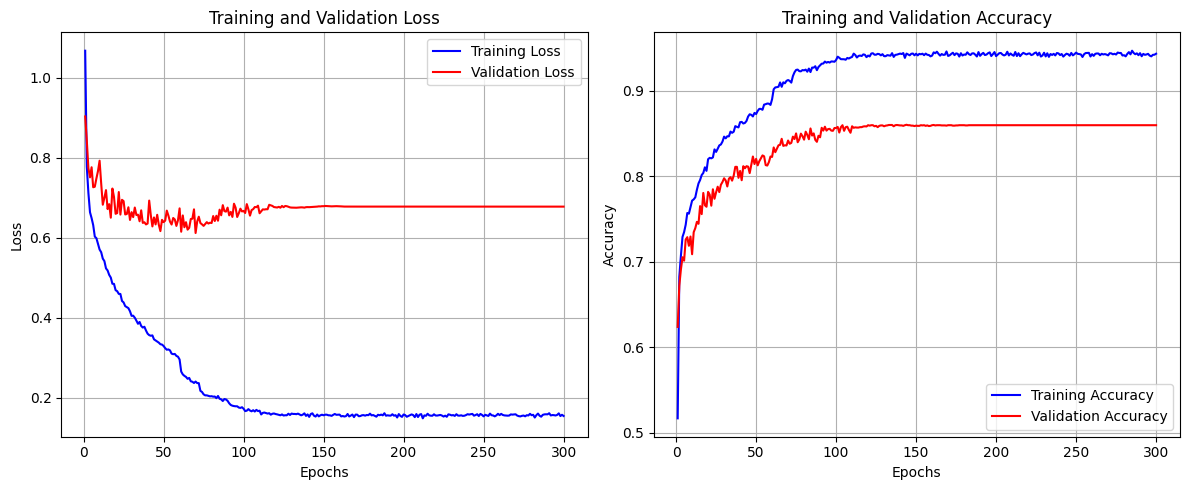

In [10]:
import matplotlib.pyplot as plt

# Modify the training loop to store metrics
# train_losses = []
# train_accs = []
# val_losses = []
# val_accs = []

# for epoch in range(1, num_epochs + 1):
#     # Training phase
#     train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
#     train_losses.append(train_loss)
#     train_accs.append(train_acc)
    
#     # Evaluation phase
#     val_loss, val_acc, val_report = evaluate(model, test_loader, criterion, device)
#     val_losses.append(val_loss)
#     val_accs.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()